### Image Processing With a CNN 
Distinguish images of dogs from cats<br>
Data:<br>
https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition

### CNN model

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import time

In [2]:
# prepare dir for unzipped images
os.makedirs('my_images', exist_ok=True)
unzip_dn = 'my_images'
train_dn = unzip_dn+'/train'
test_dn = unzip_dn+'/test'

# set variables
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)
im_size = 224
batch_size = 64
epochs = 100

In [3]:
# unzip data if not already present
if not os.path.isdir(train_dn):
  print('unzipping...')
  with zipfile.ZipFile('drive/MyDrive/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zz:
    zz.extractall(unzip_dn)
  with zipfile.ZipFile('drive/MyDrive/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zz:
    zz.extractall(unzip_dn)
  print('done')
else:
  print('image directory present')

# get list of train + test images
train_im_list = os.listdir(train_dn)
test_im_list = os.listdir(test_dn)

unzipping...
done


In [4]:
# training data: get image labels from file name
label_list = []
for file in os.listdir(train_dn):
  if (file.split('.')[0]=='dog'): label_list.append(str(1))
  elif (file.split('.')[0]=='cat'): label_list.append(str(0))
  
# training data: get df of images and labels
df = pd.DataFrame({'filename':train_im_list, 'label':label_list})
print(df.shape)
df.head()

(25000, 2)


,filename,label
0,dog.8289.jpg,1
1,cat.6354.jpg,0
2,dog.5338.jpg,1
3,cat.11123.jpg,0
4,dog.11425.jpg,1


In [5]:
# train val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=random_state)
print('train:', train_df.shape, '; val:', val_df.shape)

train: (20000, 2) ; val: (5000, 2)


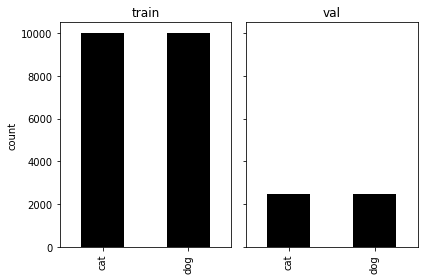

In [6]:
# label class distribution; verify stratified train/val split
fig, axs = plt.subplots(1,2, sharey=True)
train_df['label'].map({'1':'dog', '0':'cat'}).value_counts().plot(kind='bar', color='k', ax=axs[0])
val_df['label'].map({'1':'dog', '0':'cat'}).value_counts().plot(kind='bar', color='k', ax=axs[1])
axs[0].set(title='train', ylabel='count')
axs[1].set(title='val')
fig.tight_layout()
plt.show()

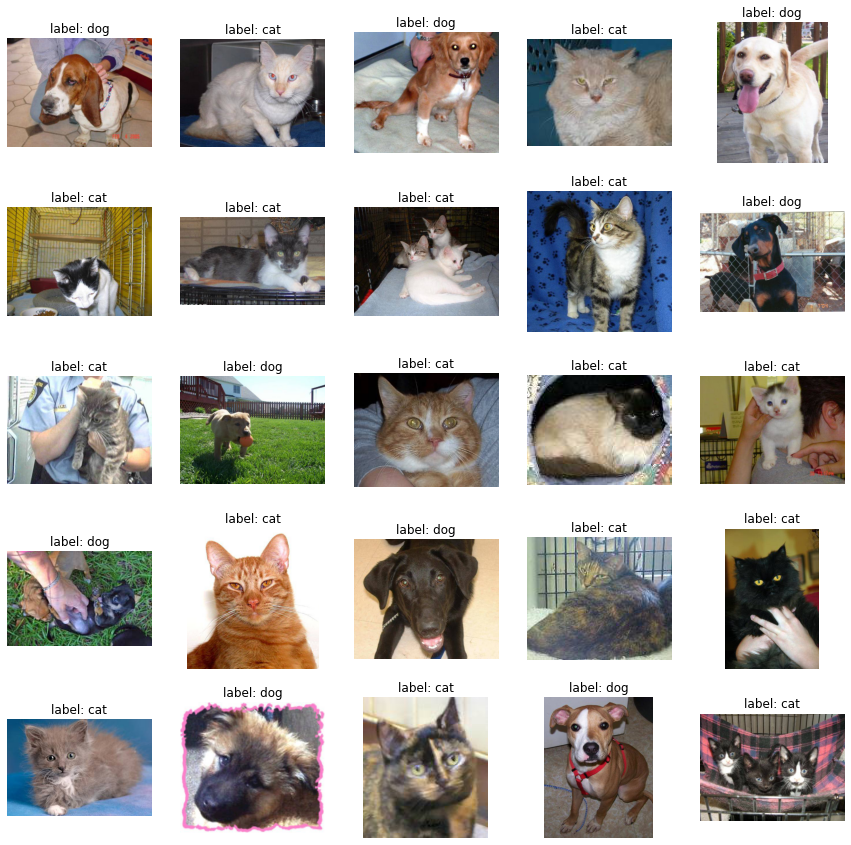

In [7]:
# visualize train data; plot 25 samples
fig, axs = plt.subplots(5, 5, figsize = (15, 15))
for ii, ax in enumerate(axs.flat):
  ax.imshow(Image.open(os.path.join(train_dn, train_im_list[ii])))
  ax.axis('off')
  ax.set_title('label: {}'.format(train_im_list[ii].split('.')[0]))
plt.show()
fig.savefig('train_example.pdf', format='pdf', bbox_inches='tight')

In [8]:
# real-time image augmentation on training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, width_shift_range=0.2, 
                                                                height_shift_range=0.2, zoom_range=0.2,
                                                                shear_range=0.2, rescale=1./255,
                                                                horizontal_flip=True, fill_mode='nearest', 
                                                                )

train_gen = train_datagen.flow_from_dataframe(train_df, directory =train_dn, x_col='filename', 
                                              y_col='label', target_size=(im_size, im_size),
                                              batch_size=batch_size, class_mode='binary')

# no augmentation on validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(val_df, directory=train_dn, x_col='filename', 
                                          y_col='label', target_size=(im_size, im_size),
                                          batch_size=batch_size, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
# construct model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(im_size, im_size, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     5

In [10]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, 
                                                 min_lr=0.0001)

In [11]:
# compile model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# fit model, get fit time
start_time = time.time()
model.fit(train_gen, epochs=epochs, validation_data=val_gen, 
          callbacks=[es, reduce_lr],
          )
print(f'fit time: {time.time()-start_time:.0f} seconds')

Epoch 1/100
313/313 [==============================] - 308s 906ms/step - loss: 2.1848 - accuracy: 0.5903 - val_loss: 0.6938 - val_accuracy: 0.5232
Epoch 2/100
313/313 [==============================] - 277s 886ms/step - loss: 0.6178 - accuracy: 0.6688 - val_loss: 0.5602 - val_accuracy: 0.7100
Epoch 3/100
313/313 [==============================] - 276s 881ms/step - loss: 0.5112 - accuracy: 0.7554 - val_loss: 0.5517 - val_accuracy: 0.7014
Epoch 4/100
313/313 [==============================] - 277s 884ms/step - loss: 0.3848 - accuracy: 0.8270 - val_loss: 0.5716 - val_accuracy: 0.7794
Epoch 5/100
313/313 [==============================] - 276s 881ms/step - loss: 0.2913 - accuracy: 0.8750 - val_loss: 0.2919 - val_accuracy: 0.8610
Epoch 6/100
313/313 [==============================] - 289s 922ms/step - loss: 0.2360 - accuracy: 0.9016 - val_loss: 0.2743 - val_accuracy: 0.8924
Epoch 7/100
313/313 [==============================] - 283s 904ms/step - loss: 0.2055 - accuracy: 0.9182 - val_loss: 0

In [12]:
# save model
model.save('drive/MyDrive/model_cnn3_v4')

INFO:tensorflow:Assets written to: drive/MyDrive/model_cnn3_v4/assets


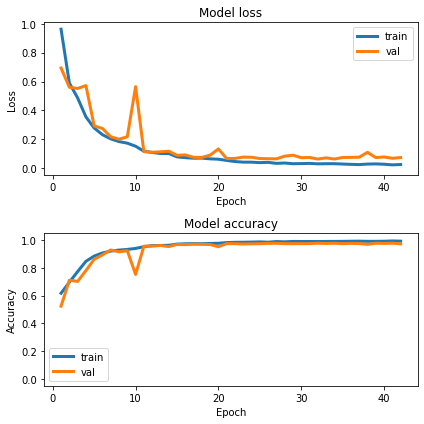

In [13]:
# plot training history
df_plot = pd.DataFrame(model.history.history)
fig, axs = plt.subplots(2,1, figsize=(6,6))
axs[0].plot(df_plot.index+1, df_plot['loss'], lw=3, label='train')
axs[0].plot(df_plot.index+1, df_plot['val_loss'], lw=3, label='val')
axs[0].set(title='Model loss', ylabel='Loss')
axs[1].plot(df_plot.index+1, df_plot['accuracy'], lw=3, label='train')
axs[1].plot(df_plot.index+1, df_plot['val_accuracy'], lw=3, label='val')
axs[1].set(title='Model accuracy', ylabel='Accuracy')
axs[0].set_ylim([-0.05, None])
axs[1].set_ylim([-0.05, 1.05])
for ax in axs:
  ax.set_xlabel('Epoch')
  ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('train_hist.pdf', format='pdf', bbox_inches='tight')

In [14]:
# test set
test_df = pd.DataFrame({'filename':test_im_list})
print(test_df.shape)
test_df.head()

(12500, 1)


,filename
0,2728.jpg
1,7367.jpg
2,6033.jpg
3,10294.jpg
4,7946.jpg


In [15]:
# prepare test data the same way
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(test_df, directory=test_dn, x_col='filename', 
                                            y_col=None, target_size=(im_size, im_size),
                                            batch_size=batch_size, class_mode=None, shuffle=False)

# predict
y_pred = model.predict(test_gen)

Found 12500 validated image filenames.


In [16]:
sample_submission = pd.read_csv('drive/MyDrive/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission = sample_submission.copy()
# match image id and predicted label
for ii, fn in enumerate(test_im_list):
  submission.at[int(fn.split('.')[0])-1, 'label'] = y_pred[ii]
submission.to_csv('cnn3_v4_submission1.csv', index=False)
submission.head()

,id,label
0,1,1.000000
1,2,1.000000
2,3,1.000000
3,4,1.000000
4,5,0.000178


In [17]:
# Kaggle's log loss evaluation penalizes overconfident models 
# strategy: send probabilities that are more reasonable, not 0 and 1
submission['label'].clip(lower=0.005, upper=0.995, inplace=True)
submission.to_csv('cnn3_v4_submission1_clip.csv', index=False)
submission.head()

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
